In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
from torch_geometric.data import Data

load data from google drive: https://drive.google.com/drive/folders/1ufRGISCS4hOSuJjpJ36ydkvxrTZ64Nlp?usp=drive_link

In [ ]:
import pickle
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

with open('/content/drive/MyDrive/paper/raw_data.pickle','rb') as pickled_data:
    data = pickle.load(pickled_data)

Mounted at /content/drive


In [ ]:
from datetime import date
def parse(date_string):
    '''
      Change date into list of integers
    '''
    return [int(i) for i in date_string.split('-')]

def get_split_index(start_index,end_index,start_date="2013-01-01",end_date="2021-12-31"):
    '''
    Calculate the start and end indices for a given date range.

    Args:
        start_index (str): The start date index in the format 'YYYY-MM-DD'.
        end_index (str): The end date index in the format 'YYYY-MM-DD'.
        start_date (str): The start date of the date range in the format 'YYYY-MM-DD'.
        end_date (str): The end date of the date range in the format 'YYYY-MM-DD'.

    Returns:
        tuple: A tuple containing two integers:
            - index_start (int): The number of days from the start_date to start_index.
            - index_end (int): The number of days from the start_date to end_index, plus one.
    '''
    ys,ms,ds = parse(start_index)
    ye,me,de = parse(end_index)
    ysd,msd,dsd = parse(start_date)
    yed,med,ded = parse(end_date)
    start_time = date(ys,ms,ds)
    end_time   = date(ye,me,de)
    start_time_date = date(ysd,msd,dsd)
    end_time_date   = date(yed,med,ded)
    index_start = (start_time - start_time_date).days
    index_end   = (end_time - start_time_date).days+1
    if index_start < 0 or (end_time - end_time_date).days > 0 or end_time==start_time:
        raise ValueError(f'index date invalid with condition {index_start} < 0 or {(end_time - end_time_date).days} > 0 or {end_time} == {start_time}')
    return index_start,index_end

Each .pickle file contains data indexed sequentially. The get_nodes function combines the last five days of data into a single unit for each grid point, considering the land-sea mask. The land-sea mask groups together grid points across different days that share the same land or sea classification.

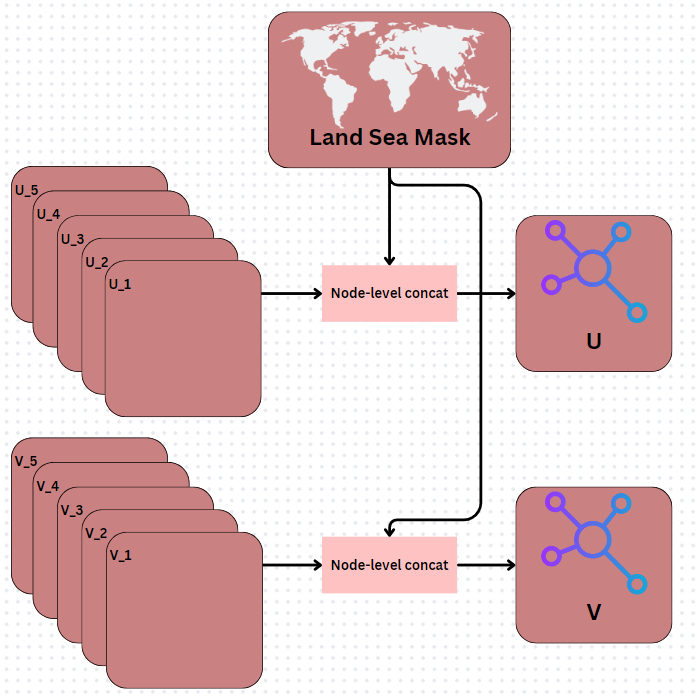

## Land-Sea Mask Function

In [ ]:
#init template data for land-sea mask
template_data = torch.isnan(torch.cat([torch.tensor(np.array(data['center'])),
           torch.tensor(np.array(data['u_geos'])),
           torch.tensor(np.array(data['v_geos']))])).any(dim=0)

#as the data is structured as R^2 array it needs to be indexed based land-sea mask
def get_base_index(template_data):
    """
    Creates a 2D array of indices based on the given template data.

    For each non-zero element in the template data, its corresponding index is added to the result array.
    For zero elements, NaN is added. The resulting array is reshaped to 91x195.

    Args:
      template_data: A 2D NumPy array.

    Returns:
      A 2D NumPy array of indices and NaN values, with shape (91, 195).
    """
    base = []
    x_size = template_data.shape[1]
    y_size = template_data.shape[0]
    i = 0
    for y in range(y_size):
        for x in range(x_size):
            #init size
            if ~template_data[y,x]:
                base.append(i)
                i = i + 1
            else:
                base.append(np.nan)
    return np.array(base).reshape(91,195)

def get_edge(template_data, base):
    """
    Creates an edge list based on the given template data and base indices.

    For each non-zero element in the template data, checks its neighboring elements.
    If a neighbor is also non-zero, an edge connecting the corresponding base indices is added to the result.

    Args:
      template_data: A 2D NumPy array representing the template data.
      base: A 2D NumPy array containing base indices.

    Returns:
      A 2D NumPy array representing the edge list, where each row contains two base indices connected by an edge.
    """
    #init size
    x_size = template_data.shape[1]
    y_size = template_data.shape[0]

    #init edges = []
    edges = []
    for y in range(y_size):
        for x in range(x_size):
            if ~template_data[y,x]:
                #edge pointer
                north,south,east,west = y + 1, y - 1, x + 1, x - 1

                #north
                if north < 91:
                    if ~template_data[north,x]:
                        edges.append([base[y,x],base[north,x]])

                #south
                if south > -1:
                    if ~template_data[south,x]:
                        edges.append([base[y,x],base[south,x]])

                #west
                if west > -1:
                    if ~template_data[y,west]:
                        edges.append([base[y,x],base[y,west]])

                #east
                if east < 195:
                    if ~template_data[y,east]:
                        edges.append([base[y,x],base[y,east]])
            #if ~template_data[y,x]:
            #


    edges = np.array(edges).T
    return edges

In [ ]:
def get_nodes(data, mask_data, number_in,number_out,start_index="2013-01-01",end_index="2021-12-31"):
    """
    Extracts nodes and their associated data from the given dataset.

    Calculates start and end indices based on input parameters and data length.
    Iterates over the specified time range, extracting latitude, longitude, input data (x_ADT, u_geos, v_geos)
    for the previous `number_in` time steps, and output data (u_geos, v_geos) for the next `number_out` time steps.
    Returns input and output data as NumPy arrays.

    Args:
      data: A dictionary containing data for each time step, including 'lat', 'lon', 'center', 'u_geos', and 'v_geos'.
      mask_data: A boolean mask indicating valid nodes.
      number_in: Number of input time steps.
      number_out: Number of output time steps.
      start_index: Start date for the data (default: "2013-01-01").
      end_index: End date for the data (default: "2021-12-31").

    Returns:
      A tuple of two NumPy arrays:
        - X: Input data with shape (number_of_nodes, number_in + 3, number_of_time_steps).
        - Y: Output data with shape (number_of_nodes, number_out * 2, number_of_time_steps).
    """
    start, end = get_split_index(start_index,end_index,start_date="2013-01-01",end_date="2021-12-31")
    number_in = number_in - 1
    nodes_mask = np.where(~mask_data.flatten())
    data_length = len(data['center'])
    if data_length - number_out <= end:
        end = data_length - number_out

    if start - number_in <= 1:
        start = max(start,number_in-start)
    else:
        start = start + 1
    Y = []
    X = []
    for i in range(start,end):

        lat   = data['lat'][i].flatten()[nodes_mask]
        lon   = data['lon'][i].flatten()[nodes_mask]

        arr= [lat,lon]
        for num_in in range(number_in+1):

            x_ADT = data['center'][i-num_in].flatten()[nodes_mask]
            u_geos= data['u_geos'][i-num_in].flatten()[nodes_mask]
            v_geos= data['v_geos'][i-num_in].flatten()[nodes_mask]
            arr.append(x_ADT)
            arr.append(u_geos)
            arr.append(v_geos)
        X.append(arr)

        arr = []
        for num_out in range(1,number_out+1):
            u_geos= data['u_geos'][i+num_out].flatten()[nodes_mask]
            v_geos= data['v_geos'][i+num_out].flatten()[nodes_mask]
            arr.append(u_geos)
            arr.append(v_geos)
        arr = arr[::2] + arr[1::2]
        Y.append(arr)
    X = np.array(X).transpose(0,2,1)
    Y = np.array(Y).transpose(0,2,1)

    return X,Y

construct graph data from image data

In [ ]:
x_nodes,y_nodes = get_nodes(data,template_data,7,5, start_index="2013-01-01",end_index="2018-12-31")
x_nodes_test,y_nodes_test = get_nodes(data,template_data,7,5, start_index="2018-12-31", end_index="2021-12-31")

## Model

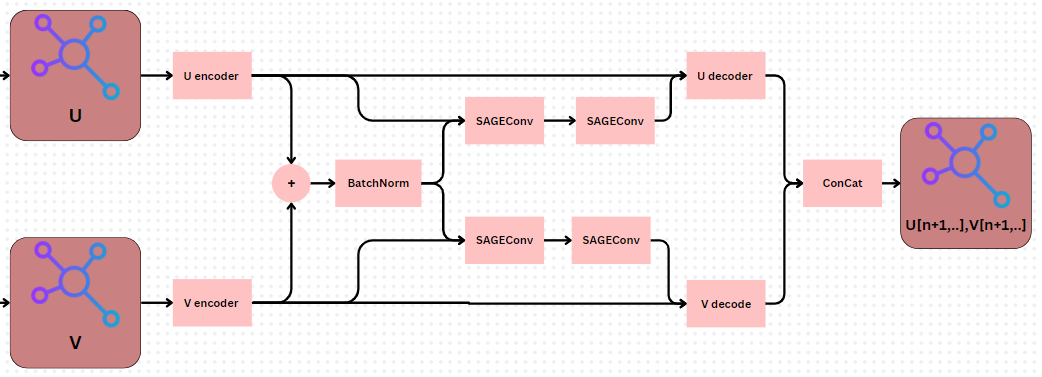

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv,LayerNorm,SAGEConv
import torch_geometric.transforms as T

class GCN(torch.nn.Module):
    def __init__(self, input_dim_temporal, hidden_dim, output_dim,
                 dropout):
        # TODO: Implement a function that initializes self.convs,
        # self.bns, and self.softmax.
        super(GCN, self).__init__()
        input_dim = int(input_dim_temporal*2+2)
        output_dim = int(output_dim/2)
        hidden_decoder_dim = int(hidden_dim*2)
        self.node_encoder_right = torch.nn.Sequential(torch.nn.Linear(input_dim , hidden_dim),
                                                      torch.nn.ReLU(),
                                                      #torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear(hidden_dim, hidden_dim),
                                                      torch.nn.ReLU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      )

        self.conv1_right = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='max')#, add_self_loops=True)
        self.conv2_right = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='max')#, add_self_loops=True)

        self.node_decoder_right = torch.nn.Sequential(torch.nn.Linear( hidden_decoder_dim , hidden_dim),
                                                      torch.nn.ReLU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear( hidden_dim , hidden_dim),
                                                      torch.nn.ReLU(),
                                                      #torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear( hidden_dim, output_dim)
                                                      )

        #left for v component
        self.node_encoder_left = torch.nn.Sequential(torch.nn.Linear(input_dim , hidden_dim),
                                                      torch.nn.ReLU(),
                                                      #torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear(hidden_dim, hidden_dim),
                                                      torch.nn.ReLU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      )

        self.conv1_left = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='max')#, add_self_loops=True)
        self.conv2_left = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='max')# add_self_loops=True)

        self.node_decoder_left = torch.nn.Sequential(torch.nn.Linear( hidden_decoder_dim, hidden_dim),
                                                      torch.nn.ReLU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear( hidden_dim , hidden_dim),
                                                      torch.nn.ReLU(),
                                                      #torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear( hidden_dim, output_dim)
                                                      )

        self.layer_norm_join = torch.nn.BatchNorm1d(hidden_dim)

        self.batch_norm2 =  torch.nn.BatchNorm1d(num_features=hidden_dim)
        self.batch_normconv_r1 =  torch.nn.BatchNorm1d(num_features=hidden_dim)
        self.batch_normconv_l1 =  torch.nn.BatchNorm1d(num_features=hidden_dim)
        self.dropout_r =  torch.nn.Dropout(dropout)
        self.dropout_l =  torch.nn.Dropout(dropout)

    def forward(self, data_right, data_left, adj_t, Training=True):
        data_right = self.node_encoder_right(data_right)
        data_left  = self.node_encoder_left(data_left)
        data_join  = self.batch_norm2(data_right + data_left)

        data_right_graph = self.batch_normconv_r1(self.conv1_right(data_right+data_join,adj_t))
        data_right_graph = self.conv2_right(data_right_graph,adj_t)

        data_left_graph  = self.batch_normconv_l1(self.conv1_left(data_left+data_join,adj_t))
        data_left_graph  = self.conv2_left(data_left_graph,adj_t)

        if Training:
            data_right = self.dropout_r(torch.cat([data_right_graph,data_right],dim=1))
            data_left  = self.dropout_l(torch.cat([data_left_graph,data_left],dim=1))
        else:
            data_right = torch.cat([data_right_graph,data_right],dim=1)
            data_left  = torch.cat([data_left_graph,data_left],dim=1)

        data_right = self.node_decoder_right(data_right)
        data_left  = self.node_decoder_left(data_left)
        out = torch.cat([data_right,data_left],dim=1)
        # x = self.node_encoder(x)
        # skip1 = x
        # x2 = F.gelu(self.conv1(x,adj_t))

        # x2 = F.gelu(self.conv2(x2,adj_t))
        # x = x2+skip1
        # #x = F.gelu(self.conv3(x2,adj_t))
        # #skip2 = x
        # #x3 = F.gelu(self.conv4(x,adj_t))
        # #x = x3+skip2
        # #x = F.gelu(self.conv5(x,adj_t))
        # #x = x + skip1
        # out = self.node_decoder(x)

        return out

load data as batch

In [ ]:
from torch_geometric.data import DataLoader,Data
base = get_base_index(template_data)
edge_index = torch.tensor(np.array(get_edge(template_data,base)), dtype=torch.int64)

# create graph tensor
x_nodes, y_nodes            = torch.tensor(np.array(x_nodes),dtype=torch.float32), torch.tensor(y_nodes,dtype=torch.float32)
x_nodes_test, y_nodes_test  = torch.tensor(np.array(x_nodes_test),dtype=torch.float32), torch.tensor(y_nodes_test,dtype=torch.float32)

# load into geometric dataset
train_dataset = [Data(x=node_features, edge_index=edge_index, y=node_target) for node_features, node_target in zip(x_nodes, y_nodes)]
test_dataset = [Data(x=node_features, edge_index=edge_index, y=node_target) for node_features, node_target in zip(x_nodes_test, y_nodes_test)]

# load geometric dataset into batch-able data
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

Function for metrics MSE and Difference Loss

*   Difference Loss is modified loss from:

Gopakumar, V., Pamela, S., Zanisi, L., Li, Z., Gray, A., Brennand, D., ... & MAST Team. (2024). Plasma surrogate modelling using Fourier neural operators. Nuclear Fusion, 64(5), 056025.

In [ ]:
import torch
import torch.nn as nn

class DifferenceLoss(nn.Module):
    def __init__(self, epsilon=0.001):
        """
        Initialize the loss function.

        Args:
            alpha (float): The weight given to L1 loss. (1 - alpha) will be the weight for L2 loss.
        """
        super(DifferenceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, outputs, targets):
        """
        Calculate the combined L1 and L2 loss.

        Args:
            outputs (torch.Tensor): The predictions of the model.
            targets (torch.Tensor): The actual values.

        Returns:
            torch.Tensor: The calculated loss.
        """
        num_examples = outputs.size()[0]
        true = targets.reshape(num_examples,-1)
        pred = outputs.reshape(num_examples,-1)
        reconstruction_error= torch.sum(torch.pow((pred-true),2,),dim=1)

        true_diff = torch.diff(true.view(num_examples,2,-1)).view(num_examples,-1)
        pred_diff = torch.diff(pred.view(num_examples,2,-1)).view(num_examples,-1)
        difference_error    = torch.sum(torch.pow((pred_diff-true_diff),2),dim=1)

        combined_loss = torch.mean(difference_error+reconstruction_error)
        return combined_loss

from numpy import linalg as LA
def MSE(outputs, targets):
  """
  Calculate the combined L1 and L2 loss.

  Args:
    outputs (torch.Tensor): The predictions of the model.
    targets (torch.Tensor): The actual values.

    Returns:
    torch.Tensor: The calculated loss.
  """
  num_examples = outputs.shape[0]
  true = targets.reshape(num_examples,-1)
  pred = outputs.reshape(num_examples,-1)
  reconstruction_error = np.mean(np.power((pred-true),2))
  return reconstruction_error

In [ ]:
device  = torch.device('cuda')
model   = GCN(input_dim_temporal = 7,
              output_dim = 10,
              hidden_dim = 40,
              dropout    = 0.2).to(device=device)

criterion   = DifferenceLoss()#torch.nn.HuberLoss(delta=0.0011)
#V 0.1, 0.01, 0.001 (best), 0.0005 (best)
#U 0.1  0.01 0.005 0.0025 0.0011 0.001(best) 0.0009 0.0005 0.0001
optimizer = torch.optim.Adamax(model.parameters(),lr=0.0005)

In [ ]:
class Callback:
    def __init__(self):
        self.lowest_eval = float('inf')  # Initialize with a very large number

    def update(self,train_losses,test_losses,train_eval,test_eval,model):
        if test_eval[-1] < self.lowest_eval and test_eval[-1] < 0.016:
            self.lowest_eval = test_eval[-1]
            print(f"got the new lowest {self.lowest_eval}")
            name = 'GCN_experiment4_ver2'
            metadata = {'train_loss':train_losses,'test_loss':test_losses,'train eval':train_eval,'test eval':test_eval}
            with open(f'metadata_{name}.pickle','wb') as m:
              pickle.dump(metadata,m,protocol=pickle.HIGHEST_PROTOCOL)
            torch.save(model, f'model_{name}.pth')
            return True  # Return True if new lowest value is found
        return False

# callback
callback = Callback()

num_epochs = 10
train_losses = []
test_losses = []
train_eval = []
test_eval = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_eval = 0.0
    for data_batch in train_loader:

        inputs, edge = data_batch.x.to(device), data_batch.edge_index.to(device)
        optimizer.zero_grad()
        data_right = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,3::3]],dim=1).to(torch.float32)
        data_left  = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,4::3]],dim=1).to(torch.float32)
        outputs = model(data_right, data_left, edge, Training=True)
        loss = criterion(outputs, data_batch.y.to(device))
        loss.backward()
        optimizer.step()
        #
        epoch_train_eval += MSE(outputs.cpu().detach().numpy(), data_batch.y.cpu().detach().numpy())*inputs.size(0)/14374
        epoch_train_loss += loss.item()*inputs.size(0)/14374
    #
    epoch_train_eval /= len(train_loader.dataset)
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_eval.append(epoch_train_eval)
    # Evaluation phase
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_eval = 0.0
    with torch.no_grad():
        for data_batch in test_loader:
            inputs, edge = data_batch.x.to(device), data_batch.edge_index.to(device)
            data_right = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,3::3]],dim=1).to(torch.float32)
            data_left  = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,4::3]],dim=1).to(torch.float32)
            outputs = model(data_right,data_left,edge, Training= False)
            #
            loss = criterion(outputs, data_batch.y.to(device))
            epoch_test_eval += MSE(outputs.cpu().detach().numpy(), data_batch.y.cpu().detach().numpy())*inputs.size(0)/14374  # Accumulate the loss for this data_batch
            epoch_test_loss += loss.item()*inputs.size(0)/14374  # Accumulate the loss for this data_batch
    # Calculate average test loss for the epoch
    epoch_test_loss /= len(test_loader.dataset)
    #
    epoch_test_eval /= len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    test_eval.append(epoch_test_eval)
    callback.update(train_losses,test_losses,train_eval,test_eval,model)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: DiffE {epoch_train_loss:.4f}| MSE {epoch_train_eval:.4f}, Test Loss: DiffE {epoch_test_loss:.4f}| MSE {epoch_test_eval:.4f}')


got the new lowest 0.014800988402350794
Epoch [1/10], Train Loss: DiffE 0.2590| MSE 0.0209, Test Loss: DiffE 0.1807| MSE 0.0148
got the new lowest 0.013851566878715095
Epoch [2/10], Train Loss: DiffE 0.1681| MSE 0.0136, Test Loss: DiffE 0.1694| MSE 0.0139
Epoch [3/10], Train Loss: DiffE 0.1561| MSE 0.0126, Test Loss: DiffE 0.3545| MSE 0.0322
Epoch [4/10], Train Loss: DiffE 0.1509| MSE 0.0121, Test Loss: DiffE 0.4010| MSE 0.0367
Epoch [5/10], Train Loss: DiffE 0.1484| MSE 0.0119, Test Loss: DiffE 0.2319| MSE 0.0202
Epoch [6/10], Train Loss: DiffE 0.1462| MSE 0.0117, Test Loss: DiffE 0.1765| MSE 0.0146
got the new lowest 0.013167657539432854
Epoch [7/10], Train Loss: DiffE 0.1445| MSE 0.0115, Test Loss: DiffE 0.1616| MSE 0.0132
Epoch [8/10], Train Loss: DiffE 0.1431| MSE 0.0114, Test Loss: DiffE 0.8555| MSE 0.0820
Epoch [9/10], Train Loss: DiffE 0.1424| MSE 0.0113, Test Loss: DiffE 0.2612| MSE 0.0228
Epoch [10/10], Train Loss: DiffE 0.1414| MSE 0.0113, Test Loss: DiffE 0.1722| MSE 0.0141

In [ ]:
name = 'GCN_DIFFLOSS_best_2'
metadata = {'train_loss':train_losses,'test_loss':test_losses,'train eval':train_eval,'test eval':test_eval}
with open(f'metadata_{name}.pickle','wb') as m:
   pickle.dump(metadata,m,protocol=pickle.HIGHEST_PROTOCOL)
torch.save(model, f'model_{name}.pth')

In [ ]:
import shutil
name_best = './model_GCN_DIFFLOSS_best.pth'
# Source file path in Colab environment
source = f'/content/{name_best}'#model_FNO_experiment1_ver2_2.pth'

# Destination folder path in Google Drive
destination = f'/content/drive/MyDrive/paper/{name_best}'#model_FNO_experiment1_ver2_2.pth'

# Move the file
shutil.move(source, destination)

'/content/drive/MyDrive/paper/./model_GCN_DIFFLOSS_best.pth'

# PLAYGROUND

## one speed

In [ ]:
import torch.nn.functional as F

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv,LayerNorm,SAGEConv

import torch_geometric.transforms as T

class GCN(torch.nn.Module):
    def __init__(self, input_dim_temporal, hidden_dim, output_dim,
                 dropout):
        # TODO: Implement a function that initializes self.convs,
        # self.bns, and self.softmax.
        super(GCN, self).__init__()
        input_dim = int(input_dim_temporal*2+2)
        output_dim = int(output_dim)
        hidden_decoder_dim = int(hidden_dim*3)
        print(4)
        print(hidden_dim)
        print(output_dim)
        #right for u component
        self.node_encoder_right = torch.nn.Sequential(torch.nn.Linear(input_dim , hidden_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear(hidden_dim, hidden_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      )

        self.conv1_right = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='mean')#, add_self_loops=True)
        self.conv2_right = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='mean')#, add_self_loops=True)


        #left for v component
        self.node_encoder_left = torch.nn.Sequential(torch.nn.Linear(input_dim , hidden_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear(hidden_dim, hidden_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.Linear(hidden_dim, hidden_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      )

        self.conv1_left = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='mean')
        self.conv2_left = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim,aggr='mean')

        self.node_decoder_join = torch.nn.Sequential(torch.nn.Linear(hidden_decoder_dim, hidden_decoder_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.LayerNorm(hidden_decoder_dim),
                                                      torch.nn.Linear( hidden_decoder_dim , hidden_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.LayerNorm(hidden_dim),
                                                      torch.nn.Linear( hidden_dim, hidden_dim),
                                                      torch.nn.GELU(),
                                                      torch.nn.Linear( hidden_dim, output_dim)
                                                      )

        self.layer_norm_join = torch.nn.BatchNorm1d(hidden_dim)
        #self.conv3 = GCNConv(in_channels=hidden_dim, out_channels=hidden_dim, add_self_loops=True)
        #self.conv4 = GCNConv(in_channels=hidden_dim, out_channels=hidden_dim, add_self_loops=True)
        #self.conv5 = GCNConv(in_channels=hidden_dim, out_channels=hidden_dim, add_self_loops=True)

        self.batch_norm2 =  torch.nn.BatchNorm1d(num_features=hidden_dim)

        # Probability of an element getting zeroed
        self.dropout = dropout

    def forward(self, data_right, data_left, adj_t):
        data_right = self.node_encoder_right(data_right)
        data_left  = self.node_encoder_left(data_left)
        data_join  = self.batch_norm2(data_right + data_left)

        data_right_graph = self.conv1_right(data_right+data_join,adj_t)
        data_right_graph = self.conv2_right(data_right_graph,adj_t)

        data_left_graph  = self.conv1_left(data_left+data_join,adj_t)
        data_left_graph  = self.conv2_left(data_left_graph,adj_t)

        out = self.node_decoder_join(torch.cat([data_right,data_left,data_right_graph+data_left_graph],dim=1))

        return out

In [ ]:
device  = torch.device('cuda')
model   = GCN(input_dim_temporal = 1,
              output_dim = 5,
              hidden_dim = 9,
              dropout    = 0.2).to(device=device)

#criterion   = torch.nn.MSELoss()#
criterion   = torch.nn.HuberLoss(delta=0.0011)
#V 0.1, 0.01, 0.001 (best), 0.0005 (best)
#U 0.1  0.01 0.005 0.0025 0.0011 0.001(best) 0.0009 0.0005 0.0001
optimizer = torch.optim.Adam(model.parameters())

4
9
5


In [ ]:

num_epochs = 10
train_losses = []
test_losses = []
train_eval = []
test_eval = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_eval = 0.0
    for data_batch in train_loader:

        inputs, edge = data_batch.x.to(device), data_batch.edge_index.to(device)
        optimizer.zero_grad()
        data_right = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,3::3]],dim=1).to(torch.float32)
        data_left  = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,4::3]],dim=1).to(torch.float32)
        outputs = model(data_right, data_left, edge)
        loss = criterion(outputs, data_batch.y[:,:5].to(device))
        loss.backward()
        optimizer.step()
        #
        epoch_train_eval += MSE(outputs.cpu().detach().numpy(), data_batch.y[:,:5].cpu().detach().numpy())*inputs.size(0)/14374
        epoch_train_loss += loss.item()*inputs.size(0)/14374
    #
    epoch_train_eval /= len(train_loader.dataset)
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_eval.append(epoch_train_eval)
    # Evaluation phase
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_eval = 0.0
    with torch.no_grad():
        for data_batch in test_loader:
            inputs, edge = data_batch.x.to(device), data_batch.edge_index.to(device)
            data_right = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,3::3]],dim=1).to(torch.float32)
            data_left  = torch.cat([inputs[:,:2],inputs[:,2::3],inputs[:,4::3]],dim=1).to(torch.float32)
            outputs = model(data_right,data_left,edge)
            #
            loss = criterion(outputs, data_batch.y[:,:5].to(device))
            epoch_test_eval += MSE(outputs.cpu().detach().numpy(), data_batch.y[:,:5].cpu().detach().numpy())*inputs.size(0)/14374  # Accumulate the loss for this data_batch
            epoch_test_loss += loss.item()*inputs.size(0)/14374  # Accumulate the loss for this data_batch
    # Calculate average test loss for the epoch
    epoch_test_loss /= len(test_loader.dataset)
    #
    epoch_test_eval /= len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    test_eval.append(epoch_test_eval)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: DiffE {epoch_train_loss:.4f}| MSE {epoch_train_eval:.4f}, Test Loss: DiffE {epoch_test_loss:.4f}| MSE {epoch_test_eval:.4f}')
    print(MSE(outputs.cpu().detach().numpy(), data_batch.y[:,:5].cpu().detach().numpy()))


Epoch [1/10], Train Loss: DiffE 0.0001| MSE 0.0210, Test Loss: DiffE 0.0001| MSE 0.0245
0.024063708
Epoch [2/10], Train Loss: DiffE 0.0001| MSE 0.0168, Test Loss: DiffE 0.0005| MSE 0.2069
0.20670427
Epoch [3/10], Train Loss: DiffE 0.0001| MSE 0.0163, Test Loss: DiffE 0.0002| MSE 0.0345
0.031856947
Epoch [4/10], Train Loss: DiffE 0.0001| MSE 0.0160, Test Loss: DiffE 0.0001| MSE 0.0223
0.021817908
Epoch [5/10], Train Loss: DiffE 0.0001| MSE 0.0160, Test Loss: DiffE 0.0001| MSE 0.0168
0.016271047
Epoch [6/10], Train Loss: DiffE 0.0001| MSE 0.0160, Test Loss: DiffE 0.0002| MSE 0.0400
0.039598025
Epoch [7/10], Train Loss: DiffE 0.0001| MSE 0.0159, Test Loss: DiffE 0.0003| MSE 0.0663
0.067396075
Epoch [8/10], Train Loss: DiffE 0.0001| MSE 0.0158, Test Loss: DiffE 0.0002| MSE 0.0333
0.032271616
Epoch [9/10], Train Loss: DiffE 0.0001| MSE 0.0158, Test Loss: DiffE 0.0002| MSE 0.0427
0.04571833
Epoch [10/10], Train Loss: DiffE 0.0001| MSE 0.0158, Test Loss: DiffE 0.0001| MSE 0.0248
0.024806209


In [ ]:
inputs.size(0)/14374

8.0

In [ ]:
x_nodes.shape

torch.Size([2191, 14374, 5])

In [ ]:
data_batch.edge_index[:,:55472]

tensor([[    0,     0,     1,  ..., 17744, 14374, 14374],
        [  195,     1,   196,  ..., 17743, 14569, 14375]], dtype=torch.int32)

In [ ]:
edge_index

tensor([[    0,     0,     1,  ..., 17743, 17744, 17744],
        [  195,     1,   196,  ..., 17744, 17549, 17743]], dtype=torch.int32)

In [ ]:
#edge_set.difference(mask_set)
mask_set.difference(edge_set)

set()

In [ ]:
base = np.zeros_like(template_data)#*np.nan
base

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

array([[0.0000e+00, 1.0000e+00, 2.0000e+00, ...,        nan,        nan,
               nan],
       [1.6800e+02, 1.6900e+02, 1.7000e+02, ...,        nan,        nan,
               nan],
       [3.3500e+02, 3.3600e+02, 3.3700e+02, ...,        nan,        nan,
               nan],
       ...,
       [1.3833e+04, 1.3834e+04, 1.3835e+04, ..., 1.4011e+04, 1.4012e+04,
        1.4013e+04],
       [1.4014e+04, 1.4015e+04, 1.4016e+04, ..., 1.4190e+04, 1.4191e+04,
        1.4192e+04],
       [1.4193e+04, 1.4194e+04, 1.4195e+04, ..., 1.4371e+04, 1.4372e+04,
        1.4373e+04]])

In [ ]:
template_data

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [ ]:

def get_nodes(data, mask_data, number_in,number_out,start_index="2013-01-01",end_index="2021-12-31"):
    start, end = get_split_index(start_index,end_index,start_date="2013-01-01",end_date="2021-12-31")
    number_in = number_in - 1
    nodes_mask = np.where(~mask_data.flatten())
    data_length = len(data['center'])
    if data_length - number_out <= end:
        end = data_length - number_out
    Y = []
    X = []
    for i in range(number_in,end):

        x_ADT = data['center'][i].flatten()[nodes_mask]
        lat   = data['lat'][i].flatten()[nodes_mask]
        lon   = data['lon'][i].flatten()[nodes_mask]

        arr= [x_ADT,lat,lon]
        for num_in in range(number_in+1):

            u_geos= data['u_geos'][i-num_in].flatten()[nodes_mask]
            v_geos= data['v_geos'][i-num_in].flatten()[nodes_mask]
            arr.append(u_geos)
            arr.append(v_geos)
        X.append(arr)

        arr = []
        for num_out in range(1,number_out+1):

            u_geos= data['u_geos'][i+num_out].flatten()[nodes_mask]
            v_geos= data['v_geos'][i+num_out].flatten()[nodes_mask]
            arr.append(u_geos)
            arr.append(v_geos)
        Y.append(arr)


    X = np.array(X).transpose(0,2,1)
    Y = np.array(Y).transpose(0,2,1)

    return X,Y

In [ ]:
# index = 196
# center = data['center'][0].flatten()[index]
# north = data['center'][0].flatten()[index+195]
# south = data['center'][0].flatten()[index-195]
# east = data['center'][0].flatten()[index+1]
# west = data['center'][0].flatten()[index-1]
# print(f'N {north}\nS {south}\nC {center}\nE {east}\nW {west}')

array([-0.1332,  0.1743, -0.1379,  0.1694, -0.1823,  0.1282])

tensor([[-1.3375e+01,  9.3875e+01,  1.1813e+00,  7.3800e-02],
        [-1.3375e+01,  9.4125e+01,  1.1889e+00,  6.5700e-02],
        [-1.3375e+01,  9.4375e+01,  1.1953e+00,  4.9600e-02],
        ...,
        [ 9.1250e+00,  1.4188e+02,  7.3070e-01, -1.4730e-01],
        [ 9.1250e+00,  1.4212e+02,  7.3050e-01, -7.1000e-02],
        [ 9.1250e+00,  1.4238e+02,  7.3180e-01, -2.5300e-02]])

In [ ]:
data_batch_right_x = torch.cat([data_batch.x[:,:2],data_batch.x[:,2::3],data_batch.x[:,3::3]],dim=1).to(torch.float32)
data_batch_right_x

tensor([[-1.3375e+01,  9.3875e+01,  9.9010e-01,  1.2220e-01],
        [-1.3375e+01,  9.4125e+01,  9.8500e-01,  6.0400e-02],
        [-1.3375e+01,  9.4375e+01,  9.8090e-01, -1.0000e-04],
        ...,
        [ 9.1250e+00,  1.4188e+02,  9.6130e-01, -4.6000e-02],
        [ 9.1250e+00,  1.4212e+02,  9.6130e-01, -7.1600e-02],
        [ 9.1250e+00,  1.4238e+02,  9.5790e-01, -7.6200e-02]])

In [ ]:
torch.nn.Linear(4,20)(data_batch_right_x)

tensor([[-16.6226,  22.6237, -29.5258,  ..., -16.0605,  -6.8134,   7.2273],
        [-16.6966,  22.6942, -29.6160,  ..., -16.0922,  -6.8473,   7.2741],
        [-16.7703,  22.7650, -29.7060,  ..., -16.1239,  -6.8807,   7.3206],
        ...,
        [-33.7888,  41.6029, -51.7240,  ..., -19.9033,  -7.8027,  21.6435],
        [-33.8519,  41.6731, -51.8126,  ..., -19.9379,  -7.8258,  21.6813],
        [-33.9082,  41.7407, -51.9013,  ..., -19.9743,  -7.8430,  21.7140]],
       grad_fn=<AddmmBackward0>)

In [ ]:
data_batch.x[:,4::3]

tensor([[-0.0981],
        [-0.0743],
        [-0.0583],
        ...,
        [-0.0654],
        [-0.0025],
        [ 0.0378]])